## Пример для хакатона осеннего семестра первого курса магистратуры "Инженерия машинного обучения"

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (Файл->Сохранить копию на диске...). Свою копию вы сможете изменять и запускать.

Не забудьте включить GPU (Среда выполнения->Сменить среду выполнения->Аппаратный ускоритель->GPU)

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline 

## Загружаем данные

In [2]:
!wget https://www.dropbox.com/s/oie7kwgm6yrp4hf/train.zip?dl=1  -O train.zip

--2023-01-19 18:20:11--  https://www.dropbox.com/s/oie7kwgm6yrp4hf/train.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/oie7kwgm6yrp4hf/train.zip [following]
--2023-01-19 18:20:11--  https://www.dropbox.com/s/dl/oie7kwgm6yrp4hf/train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucab1f1801ad27fc3d97457c9eeb.dl.dropboxusercontent.com/cd/0/get/B01yN7f94uVIMLzXZ1MFSA8VcW_5xe2dG_uky7QNXNSOTRzCz-p10D8Tn1GZ63O9KrlP59OAX4c4dPCgKEFNJdEcugAbU70S145dM6J3TqGIZJ5de0M0M3oQYJBYJBwWRTaKKkDI0KGF5EUsWT2Cve5Cd5KUvhHmV6ST_7jESx-i2qdEjt2OeTKOLaTxkh2sfQY/file?dl=1# [following]
--2023-01-19 18:20:12--  https://ucab1f1801ad27fc3d97457c9eeb.dl.dropboxusercontent.com/cd/0/get/B01yN7f94uVIMLzXZ1MFSA8VcW_5xe2dG_uky7QNXNSOTRzCz-p10D8Tn1GZ63O

In [3]:
!wget https://www.dropbox.com/s/i3w7o0chac7nr2t/test.zip?dl=1 -O test.zip

--2023-01-19 18:21:08--  https://www.dropbox.com/s/i3w7o0chac7nr2t/test.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/i3w7o0chac7nr2t/test.zip [following]
--2023-01-19 18:21:08--  https://www.dropbox.com/s/dl/i3w7o0chac7nr2t/test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7680f1980ccee1154a4e0fd50c.dl.dropboxusercontent.com/cd/0/get/B02rtV9e4VcEunojl4w29jfj0PwSdD6zYa6ypIe6DmZaidvYoTFlbdy50K0jFbuSqIZ60XSHvKIcsbqOyG8g13oKqEKGYEHokUHYBe8hvhyx3L0bXl9gOFrc-e7UdIFW8CAilQu2iucsXASySk4d5iqK0Ckfc2DTTOtbkgecWDRJtZi_U1ATMiJGlLlbPBz1e7I/file?dl=1# [following]
--2023-01-19 18:21:11--  https://uc7680f1980ccee1154a4e0fd50c.dl.dropboxusercontent.com/cd/0/get/B02rtV9e4VcEunojl4w29jfj0PwSdD6zYa6ypIe6DmZaidvYoTFlbdy50K0jFbuSqI

In [4]:
!ls

sample_data  test.zip  train.zip


In [5]:
!unzip -q train.zip

In [6]:
!ls train

by  ru


In [7]:
!unzip -q test.zip

In [8]:
!ls test

by  ru


Смотрим примеры картинок

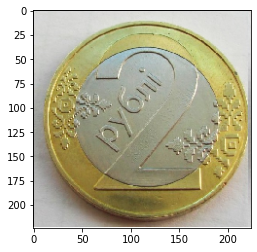

In [9]:
img_path = 'train/by/by0.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

## Создаем наборы данных

Набор данных для обучения

In [10]:
train_dataset = image_dataset_from_directory('train',
                                             batch_size=128,
                                             image_size=(224, 224))

Found 600 files belonging to 2 classes.


In [11]:
class_names = train_dataset.class_names

In [12]:
class_names

['by', 'ru']

Набор данных для тестирования

In [13]:
test_dataset = image_dataset_from_directory('test',
                                             batch_size=100,
                                             image_size=(224, 224))

Found 100 files belonging to 2 classes.


## Создаем составную нейронную сеть

In [14]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [15]:
inputs = layers.Input(shape=(224, 224, 3))
x = img_augmentation(inputs)
model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
# Для задачи с двумя классами изображений
outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)
# Для задачи с несколькими классами изображений
# num_classes = 3 # Задаем количество классов
# outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
model = tf.keras.Model(inputs, outputs, name="EfficientNet")

16705208/16705208 [==============================] - 2s 0us/step


Компилируем составную нейронную сеть

In [16]:
# Для задачи с двумя классами изображений
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
# Для задачи с несколькими классами изображений
# model.compile(loss='categorical_crossentropy',
#              optimizer='adam', 
#              metrics=['accuracy'])

## Обучаем сеть

In [17]:
history = model.fit(train_dataset,
                    epochs=10)

Epoch 1/10


5/5 [==============================] - 39s 2s/step - loss: 0.7490 - accuracy: 0.5983
Epoch 2/10
5/5 [==============================] - 22s 2s/step - loss: 0.4832 - accuracy: 0.7567
Epoch 3/10
5/5 [==============================] - 21s 2s/step - loss: 0.3682 - accuracy: 0.8367
Epoch 4/10
5/5 [==============================] - 21s 2s/step - loss: 0.2971 - accuracy: 0.8800
Epoch 5/10
5/5 [==============================] - 21s 2s/step - loss: 0.2616 - accuracy: 0.9050
Epoch 6/10
5/5 [==============================] - 21s 2s/step - loss: 0.2365 - accuracy: 0.9150
Epoch 7/10
5/5 [==============================] - 21s 2s/step - loss: 0.1854 - accuracy: 0.9433
Epoch 8/10
5/5 [==============================] - 21s 2s/step - loss: 0.1740 - accuracy: 0.9317
Epoch 9/10
5/5 [==============================] - 22s 2s/step - loss: 0.1477 - accuracy: 0.9500
Epoch 10/10
5/5 [==============================] - 21s 2s/step - loss: 0.1537 - accuracy: 0.9383


Проверяем качество обучения на тестовом наборе данных


In [18]:
scores = model.evaluate(test_dataset, verbose=1)

1/1 [==============================] - 4s 4s/step - loss: 0.3336 - accuracy: 0.9200


In [19]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 92.0


## Использование нейронной сети для распознавания изображений

Вспоминаем номера классов

In [20]:
class_names

['by', 'ru']

Загружаем изображение из файла

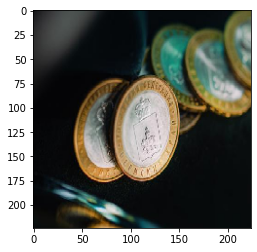

In [21]:
img_path = 'test/ru/ru135.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

Преобразуем изображение в массив

In [22]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

Запускаем распознавание

In [23]:
prediction = model.predict(x)

1/1 [==============================] - 2s 2s/step


Печатаем результаты распознавания

In [24]:
prediction

array([[0.8030966]], dtype=float32)